# Stock Trend Prediction Pipeline

## Step 0: Install Dependencies
First, we install the necessary Python libraries for our machine learning pipeline.
- `xgboost`: Implementation of the gradient boosting algorithm.
- `pandas`, `numpy`: For data manipulation and numerical operations.
- `scikit-learn`: For machine learning models and evaluation metrics.
- `matplotlib`: For plotting and data visualization.

In [ ]:


!pip install -q numpy pandas scikit-learn matplotlib xgboost


## Step 1: Import Libraries
We import the required modules.
- **Models:** `MLPClassifier` (Neural Network) and `XGBClassifier`.
- **Metrics:** Functions to calculate accuracy, precision, recall, F1-score, ROC-AUC, and to generate confusion matrices and ROC curves.
- **Visualization:** `matplotlib` is configured for plotting figures.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
)

from xgboost import XGBClassifier  # ← ADD THIS LINE
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)


## Step 2: Load Data
We load the financial dataset `merged_sentiment_price_data.csv`. This dataset likely contains historical stock prices combined with sentiment analysis scores from social media or news.
- **Outcome:** Displays the first 5 rows and the column names to verify the data loaded correctly.

In [ ]:
# ============================================
# STEP 2: LOAD DATA
# ============================================
# OPTION A: If the file is in your Colab working directory:
# Make sure you have uploaded "merged_sentiment_price_data.csv" via the folder icon in Colab.
csv_path = "merged_sentiment_price_data.csv"

# OPTION B: If you want to upload manually each time:
# from google.colab import files
# uploaded = files.upload()
# csv_path = list(uploaded.keys())[0]

df = pd.read_csv(csv_path)
print(df.head())
print(df.columns)


         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name   date_only Ticker  avg_sentiment  tweet_count  
0  53868000       TSLA  2021-09-30   TSLA       0.282787         90.0  
1  51094200       TSLA  2021-10-01   TSLA       0.240238         94.0  
2  91449900       TSLA  2021-10-04   TSLA       0.097564        119.0  
3  55297800       TSLA  2021-10-05   TSLA       0.123993         88.0  
4  43898400       TSLA  2021-10-06   TSLA       0.228447         78.0  
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Stock Name', 'date_only', '

## Step 3: Data Preprocessing
We prepare the data for supervised learning:
1.  **Sort by Date:** Ensures chronological order for time-series splitting.
2.  **Create Target:** We create a binary target variable `target`.
    * `1`: If the *next day's* closing price (`next_close`) is higher than today's close.
    * `0`: Otherwise.
3.  **Feature Selection:** We select numerical features: OHLC (Open, High, Low, Close), Volume, and sentiment metrics.
4.  **Drop NaNs:** Removes rows with missing values created by shifting the data.

- **Outcome:** A cleaned DataFrame ready for modeling.

In [ ]:
# ============================================
# STEP 3: BASIC PREPROCESSING
# - Sort by Date (time series)
# - Create next day's Close price
# - Create binary target (1 = price up tomorrow, 0 = down/same)
# - Select basic numerical features only
# ============================================

# Ensure Date is datetime and sort
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Create next-day close and target
df["next_close"] = df["Close"].shift(-1)
df["target"] = (df["next_close"] > df["Close"]).astype(int)

# Features (basic set as requested)
features = ["Open", "High", "Low", "Close", "Volume", "avg_sentiment", "tweet_count"]

# Drop rows with missing values in used columns
df_model = df.dropna(subset=features + ["next_close", "target"]).reset_index(drop=True)

print("Shape after preprocessing:", df_model.shape)
df_model.head()


Shape after preprocessing: (4184, 14)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,date_only,Ticker,avg_sentiment,tweet_count,next_close,target
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA,2021-09-30,TSLA,0.282787,90.0,281.920013,1
1,2021-09-30,285.709991,287.829987,281.619995,281.920013,278.792847,32343600,MSFT,2021-09-30,MSFT,0.248940,5.0,164.251999,0
2,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,AMZN,2021-09-30,AMZN,0.248940,5.0,149.970001,0
3,2021-09-30,608.049988,619.000000,608.049988,610.340027,610.340027,6612600,NFLX,2021-09-30,NFLX,0.271660,5.0,141.500000,0
4,2021-09-30,143.660004,144.380005,141.279999,141.500000,140.478485,89056700,AAPL,2021-09-30,AAPL,0.095886,7.0,116.339996,0


## Step 4: Train-Test Split
We split the data into training and testing sets.
- **Method:** We use a **time-based split** (first 80% for training, last 20% for testing) instead of a random shuffle. This prevents "data leakage" where the model might accidentally learn from future data to predict the past.
- **Outcome:** Prints the number of samples in the training and testing sets.

In [ ]:
# ============================================
# STEP 4: TIME-BASED TRAIN–TEST SPLIT
# - First 80% → train
# - Last 20% → test
# ============================================

X = df_model[features].values
y = df_model["target"].values

split_idx = int(len(df_model) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 3347
Test size : 837


## Step 5: Correlation Analysis
We visualize the correlation between features and the target variable.
- **Goal:** To see which features (like Sentiment or Volume) are most strongly related to the stock moving up or down.
- **Outcome:** A heatmap displaying correlation coefficients (values close to 1 or -1 indicate strong correlation).

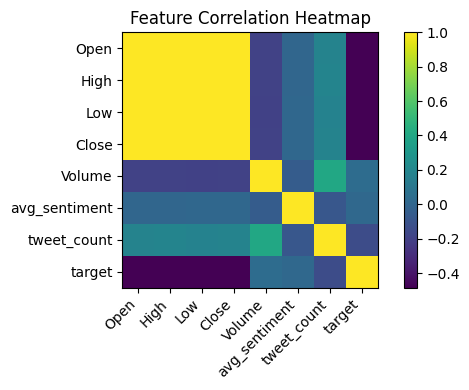

In [ ]:
# ============================================
# STEP 5: CORRELATION HEATMAP
# ============================================

corr = df_model[features + ["target"]].corr()

plt.figure()
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Feature Correlation Heatmap")
plt.colorbar()
plt.tight_layout()
plt.show()


### **Interpreting the Correlation Heatmap**

The heatmap above reveals important relationships between our features:

1.  **High Multicollinearity in Prices:**
    * The bright yellow block in the top-left shows that `Open`, `High`, `Low`, and `Close` prices are nearly perfectly correlated (correlation ≈ 1.0).
    * **Insight:** Using all of them might be redundant for some linear models, but tree-based models (like XGBoost) can handle this well.

2.  **Volume & Social Activity:**
    * `Volume` shows a moderate positive correlation (greenish square) with `tweet_count`.
    * **Insight:** High trading volume often coincides with increased social media discussion, suggesting that `tweet_count` could act as a proxy for market attention.

3.  **Target Correlation (The Challenge):**
    * Look at the bottom row labeled `target`. There are **no bright yellow squares** (strong positive correlation) or **deep dark bars** (strong negative correlation) with the feature columns.
    * **Insight:** The lack of strong linear correlation indicates that stock direction (`target`) cannot be easily predicted by a single variable alone. This confirms the need for complex, non-linear models (like Random Forest or Neural Networks) rather than simple linear rules.

## Step 6: Feature Scaling
We normalize the data using `StandardScaler`.
- **Why:** Models like Logistic Regression, SVM, and Neural Networks perform poorly when features have vastly different scales (e.g., Price is ~150, Sentiment is ~0.1). Scaling gives them mean=0 and variance=1.

In [ ]:
from sklearn.preprocessing import StandardScaler

# ============================================
# STEP 6: SCALING FOR MODELS THAT NEED IT
# - Logistic Regression, Linear SVM, MLP
# ============================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step 7: Define Classifiers
We initialize a list of machine learning models to benchmark:
1.  **Logistic Regression:** A linear baseline.
2.  **Random Forest:** An ensemble of decision trees.
3.  **Gradient Boosting:** Sequential tree building.
4.  **XGBoost:** Optimized gradient boosting.
5.  **Linear SVM:** Support Vector Machine for linear separation.
6.  **MLP (Neural Network):** Multi-Layer Perceptron for non-linear patterns.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC # Corrected import for LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

models = [
    ("Logistic Regression",
     LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
     True),

    ("Random Forest",
     RandomForestClassifier(n_estimators=300, random_state=42),
     False),

    ("Gradient Boosting",
     GradientBoostingClassifier(random_state=42),
     False),

    ("XGBoost",
     XGBClassifier(
         n_estimators=300,
         learning_rate=0.05,
         max_depth=3,
         subsample=0.8,
         colsample_bytree=0.8,
         objective="binary:logistic",
         eval_metric="logloss",
         random_state=42,
         n_jobs=-1,
     ),
     False),

    ("Linear SVM",
     LinearSVC(class_weight="balanced", random_state=42, max_iter=5000),
     True),

    ("MLP Neural Network",
     MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
     True),
]

## Step 8: Train and Evaluate
We loop through each model to train it and evaluate its performance.
- **Process:**
    1.  Fit the model on `X_train`.
    2.  Predict outcomes on `X_test`.
    3.  Calculate performance metrics (Accuracy, Precision, Recall, F1, ROC-AUC).
- **Visualization:**
    - **Confusion Matrix:** Shows True Positives, True Negatives, False Positives, and False Negatives.
    - **ROC Curve:** Plots the True Positive Rate vs. False Positive Rate at various thresholds.

- **Outcome:** A performance report for every model, helping us identify the best predictor.


==================== Logistic Regression ====================
Accuracy : 0.7085
Precision: 0.6624
Recall   : 0.8548
F1-score : 0.7464
ROC-AUC  : 0.8229


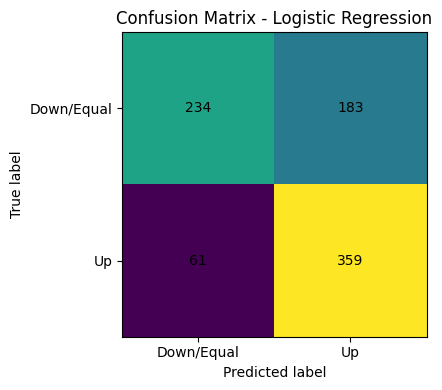

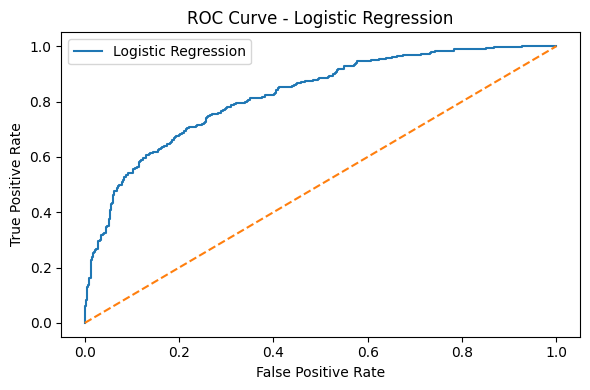


==================== Random Forest ====================
Accuracy : 0.7180
Precision: 0.7009
Recall   : 0.7643
F1-score : 0.7312
ROC-AUC  : 0.7840


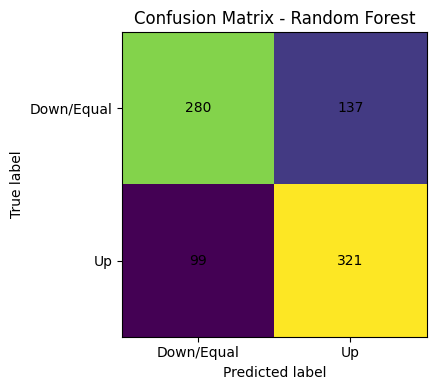

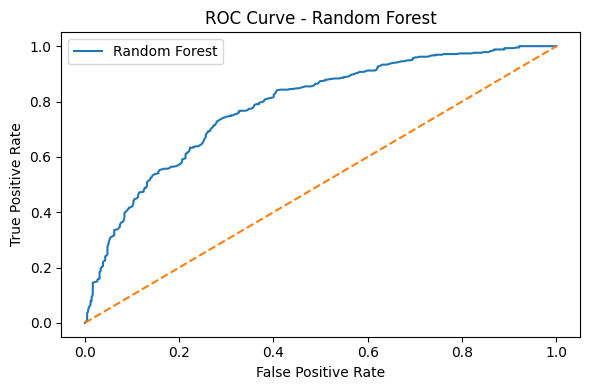


==================== Gradient Boosting ====================
Accuracy : 0.7252
Precision: 0.7013
Recall   : 0.7881
F1-score : 0.7422
ROC-AUC  : 0.8178


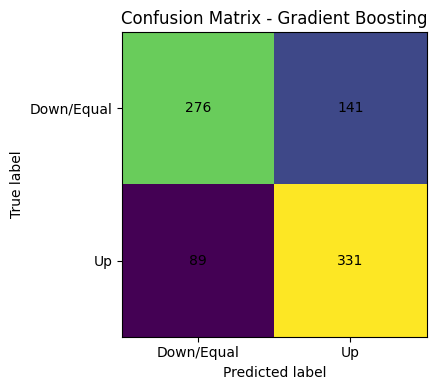

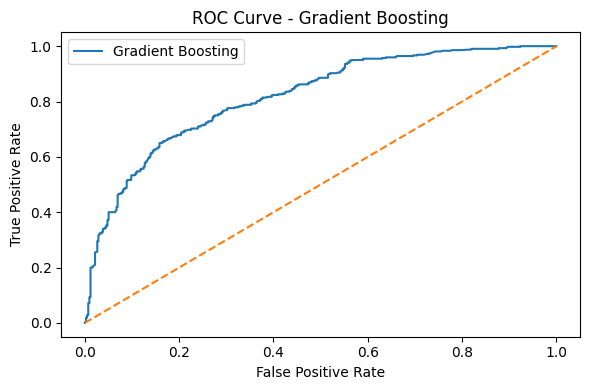


==================== XGBoost ====================
Accuracy : 0.7264
Precision: 0.7028
Recall   : 0.7881
F1-score : 0.7430
ROC-AUC  : 0.8134


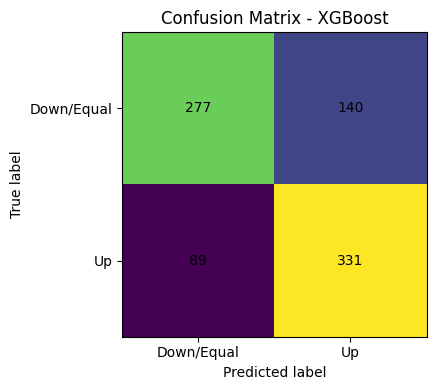

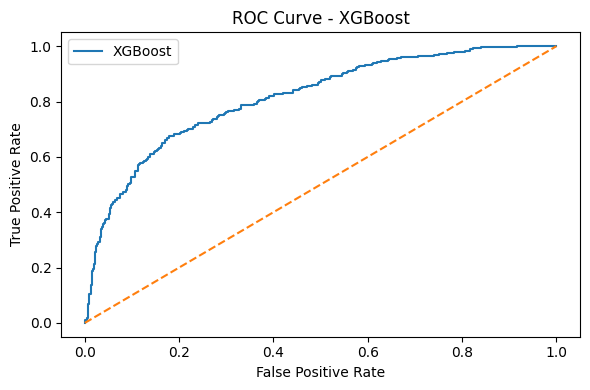


==================== Linear SVM ====================
Accuracy : 0.6953
Precision: 0.6460
Recall   : 0.8690
F1-score : 0.7411
ROC-AUC  : 0.8224


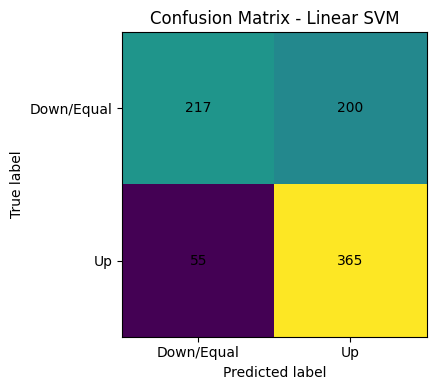

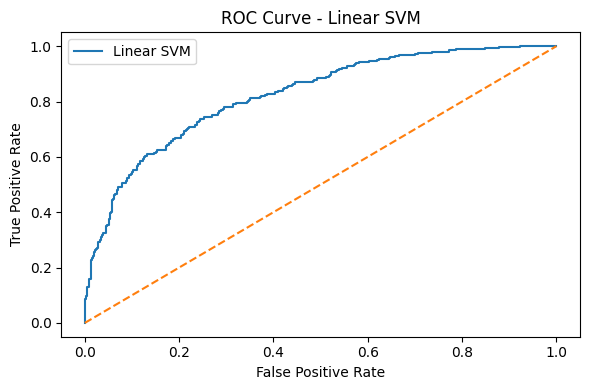


==================== MLP Neural Network ====================
Accuracy : 0.7133
Precision: 0.6907
Recall   : 0.7762
F1-score : 0.7309
ROC-AUC  : 0.8125


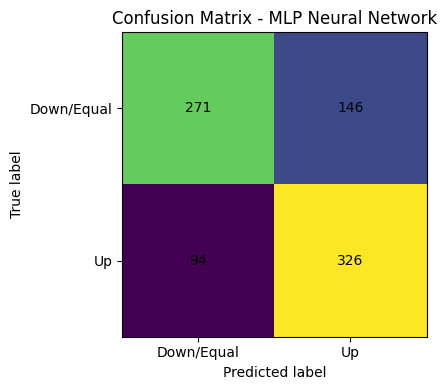

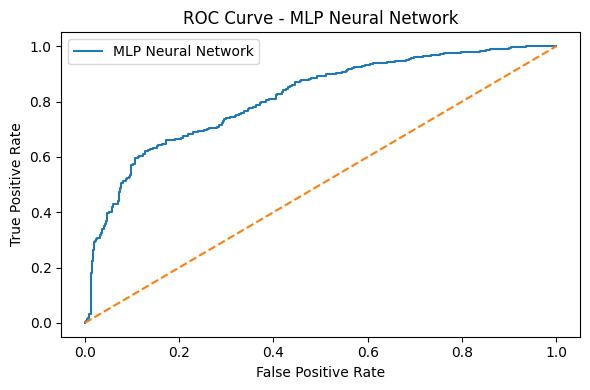

In [ ]:
# ============================================
# STEP 8: TRAIN, EVALUATE, VISUALIZE EACH MODEL
# - Confusion Matrix
# - ROC Curve (when possible)
# ============================================
import numpy as np
results = []

for name, model, use_scaled in models:
    print(f"\n==================== {name} ====================")

    Xtr = X_train_scaled if use_scaled else X_train
    Xte = X_test_scaled if use_scaled else X_test

    # Train
    model.fit(Xtr, y_train)

    # Predict
    y_pred = model.predict(Xte)

    # Get scores for ROC if available
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(Xte)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(Xte)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}" if not np.isnan(roc_auc) else "ROC-AUC  : N/A")

    results.append(
        {
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "ROC_AUC": roc_auc,
        }
    )

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {name}")
    plt.xticks([0, 1], ["Down/Equal", "Up"])
    plt.yticks([0, 1], ["Down/Equal", "Up"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    # ROC Curve (if available)
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        plt.figure()
        plt.plot(fpr, tpr, label=name)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.legend()
        plt.tight_layout()
        plt.show()


| Metric        | Meaning                                                                      |
| ------------- | ---------------------------------------------------------------------------- |
| **Accuracy**  | How often the model correctly predicts up/down movement                      |
| **Precision** | When the model predicts “price will go up”, how often it is actually correct |
| **Recall**    | Out of all actual “up” days, how many the model successfully detects         |
| **F1-score**  | Balance between precision and recall (quality of classification)             |
| **ROC-AUC**   | Ability to separate up vs down across all thresholds                         |


| Model               | Key strength                                         |
| ------------------- | ---------------------------------------------------- |
| XGBoost             | **Best Accuracy (0.7264) and F1**                    |
| Gradient Boosting   | **Consistent top performer**                         |
| Logistic Regression | **Highest recall → catches most price rises**        |
| Linear SVM          | **Very high recall but lower precision**             |
| Random Forest       | **Stable non-linear learner**                        |
| MLP                 | **Performs well but slightly below boosting models** |


## Step 9: Summary of Results
Finally, we aggregate all the metrics into a single Pandas DataFrame for easy comparison.
- **Outcome:** A table ranking models by Accuracy, F1-score, and ROC-AUC.

In [ ]:
import pandas as pd

df_results = pd.DataFrame(results)
display(df_results)

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression,0.708483,0.662362,0.854762,0.746362,0.822879
1,Random Forest,0.718041,0.700873,0.764286,0.731207,0.784044
2,Gradient Boosting,0.725209,0.701271,0.788095,0.742152,0.817809
3,XGBoost,0.726404,0.702760,0.788095,0.742985,0.813441
4,Linear SVM,0.695341,0.646018,0.869048,0.741117,0.822382
5,MLP Neural Network,0.713262,0.690678,0.776190,0.730942,0.812470
